# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from math import sqrt
import sys
%matplotlib inline

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



In [3]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

In [4]:
# Get the masked image of the canny transformation.
def get_my_vertices(image, vertical_cut):
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]*0.48, imshape[0]*vertical_cut), (imshape[1]*0.52, imshape[0]*vertical_cut), (imshape[1],imshape[0])]], dtype=np.int32)
    return vertices
    
def masked_canny(image, vertices, kernel_size=5, low_threshold=50, high_threshold=150):
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, kernel_size)
    edges = canny(blur_gray, low_threshold, high_threshold)
    masked_image = region_of_interest(edges, vertices)
    return masked_image

def image_with_lines(image, vertical_cut = 0.6, rho=2, theta=np.pi/180, threshold=30, min_line_len=10,max_line_gap=10):
    # Get vertices and masked canny image.
    vertices = get_my_vertices(image, vertical_cut)
    masked_image = masked_canny(image, vertices)
    
    # Hough transformation.
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
    
    # Combine the image with lines.
    combined_image = weighted_img(line_image, image)
    return combined_image

## Test images with lane lines highlighted.

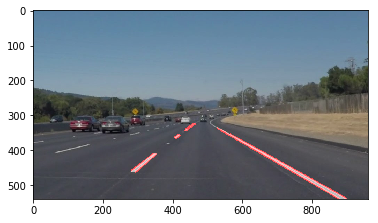

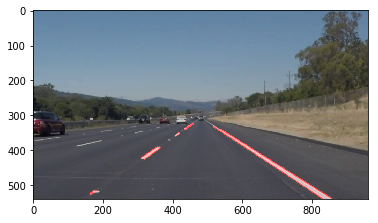

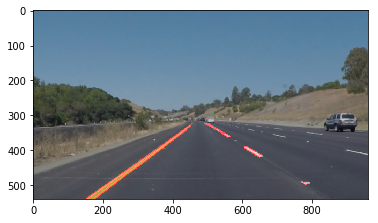

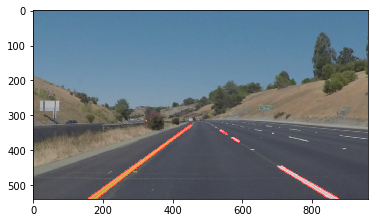

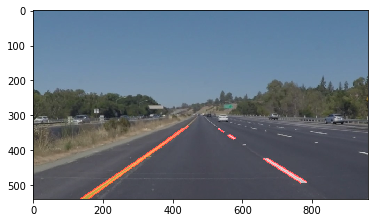

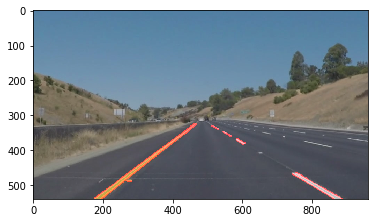

In [5]:
import os
filenames = os.listdir("test_images/")
for filename in filenames:
    image = mpimg.imread('test_images/%s' % filename)
    result_image = image_with_lines(image)
    plt.figure()
    plt.imshow(result_image)

## Extending and averaging the lines.

In [6]:
def line_length(line):
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]
    length = sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))
    return length

def get_slope(line):
    x1 = line[0][0]
    y1 = line[0][1]
    x2 = line[0][2]
    y2 = line[0][3]
    if x1 == x2:
        slope = sys.float_info.max
    else:
        slope = (y2-y1) / (x2-x1)
    return slope

def get_intercept(line):
    slope = get_slope(line)
    x1 = line[0][0]
    y1 = line[0][1]
    intercept = y1 - slope * x1
    return intercept

def get_radian(line):
    slope = get_slope(line)
    radian = np.arctan(slope)
    return radian

def good_slope(line, low_cut = 0.1, high_cut = 0.1):
    rad = get_radian(line)
    low_good = (rad > np.pi*low_cut and rad < np.pi*(1. - low_cut)) or (-np.pi*(1. - low_cut) < rad and rad < -np.pi*low_cut)
    high_good = (-np.pi*(.5 + high_cut) < rad and rad < np.pi*(.5 - high_cut)) or (.5 + high_cut)*np.pi < rad or rad < -(.5 + high_cut)*np.pi
    
    return low_good and high_good

def good_for_seed(line, min_len = 10):
    length = line_length(line)
    ok_len = length > min_len
    ok_slope = good_slope(line)
    return ok_len and ok_slope

def similar_angle(line1, line2, tol_rad = 0.2):
    rad1 = get_radian(line1)
    rad2 = get_radian(line2)
    good_rad = abs(rad1 - rad2) < tol_rad
    return good_rad
        
def belongs_to_group(last_line, line, imshape, tol_rad = 0.2):
    ok_angle = similar_angle(last_line, line)
    return ok_angle

def get_group_index(lines, sorted_index, imshape):
    group_index = []
    for i in sorted_index:
        line = lines[i]
        if len(group_index) == 0:
            if good_for_seed(line):
                group_index.append(i)
        else:
            last_line = lines[group_index[-1]]
            if belongs_to_group(last_line, line, imshape):
                group_index.append(i)
    return group_index

def get_sorted_index(lines):
    low_ends = [ max(x[0][i] for i in [1, 3]) for x in lines]
    sorted_index = np.argsort(low_ends)
    return sorted_index[::-1] # y-coordinate is reversed in image.

def subtract_list(list1, list2):
    result_list = [x for x in list1 if x not in list2]
    return result_list

def get_line_groups(lines, imshape):
    sorted_index = get_sorted_index(lines)
    
    # Get a group of lines that belongs to a lane divider.
    line_groups = []
    group_index = get_group_index(lines, sorted_index, imshape)
    while len(group_index) > 0:
        line_group = lines[group_index]
        line_groups.append(line_group)
        
        remaining_index = subtract_list(sorted_index, group_index)
        sorted_index = remaining_index
        
        # Find another group.
        group_index = get_group_index(lines, sorted_index, imshape)

    return line_groups

def is_good_group(lines, imshape, len_cut = 0.15):
    min_len = imshape[0] * len_cut
    sum_len = 0.
    for line in lines:
        sum_len += line_length(line)
    return sum_len > min_len

def get_good_groups(line_groups, imshape):
    good_groups = []
    for group in line_groups:
        if is_good_group(group, imshape):
            good_groups.append(group)
    return good_groups

def get_median(v):
    v.sort()
    return v[int(len(v)/2)]

def get_median_slope(lines):
    slopes = []
    for line in lines:
        slopes.append(get_slope(line))
    return get_median(slopes)

def get_x_intercept(line, y0):
    slope = get_slope(line)
    intercept = get_intercept(line)
    x0 = line[0][0] # default if slope == 0
    if slope != 0.:
        x0 = (y0 - intercept) / slope
    return x0

def get_median_x_intercept(lines, y0):
    x_intercepts = []
    for line in lines:
        x_intercepts.append(get_x_intercept(line, y0))
    return get_median(x_intercepts)

def get_full_line(lines, imshape, vertical_cut):
    slope = get_median_slope(lines)
    y_bottom = imshape[0]
    y_top = imshape[0] * vertical_cut
    x_bottom = get_median_x_intercept(lines, y_bottom)
    x_top = get_median_x_intercept(lines, y_top)
    return [[int(x_bottom), int(y_bottom), int(x_top), int(y_top)]]

def good_full_line(line, imshape, vertical_cut, tol_top = 0.1, tol_bottom = 2.):
    y_bottom = imshape[0]
    y_top = imshape[0] * vertical_cut
    x_bottom = get_x_intercept(line, y_bottom)
    x_top = get_x_intercept(line, y_top)
    ok_top = (1. - tol_top) * imshape[1] / 2. < x_top and x_top < (1. + tol_top) * imshape[1] / 2.
    ok_bottom = (1. - tol_bottom) * imshape[1] / 2. < x_top and x_top < (1. + tol_bottom) * imshape[1] / 2.
    return ok_top and ok_bottom

def get_full_lines(lines, imshape, vertical_cut):
    # Divide the lines into groups.
    line_groups = get_line_groups(lines, imshape)
    
    # Only retain the groups that satisfy requirements.
    good_groups = get_good_groups(line_groups, imshape)
    
    # Get the filler lines for each line group.
    full_lines = []
    for grouped_lines in good_groups:
        full_line = get_full_line(grouped_lines, imshape, vertical_cut)
        if good_full_line(full_line, imshape, vertical_cut):
            full_lines.append(full_line)
    return full_lines

def hough_full_lines(image, vertical_cut, rho, theta, threshold, min_line_len, max_line_gap):
    # Get Hough lines from canny image.
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # Add the lines that fill the gaps.
    full_lines = get_full_lines(lines, image.shape, vertical_cut)
    
    # Create an image with the lines.
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_image, full_lines)
    
    # Apply mask with vertices.
    return line_image

def image_with_full_lines(image, vertical_cut = 0.6, rho=2, theta=np.pi/180, threshold=30, min_line_len=10, max_line_gap=10):
    # Get vertices and masked canny image.
    vertices = get_my_vertices(image, vertical_cut)
    masked_image = masked_canny(image, vertices)
    
    # Hough transformation with extended lines.
    line_image = hough_full_lines(masked_image, vertical_cut, rho, theta, threshold, min_line_len, max_line_gap)

    # Combine the image with lines.
    combined_image = weighted_img(line_image, image)
    return combined_image

## Test imges with extended lines.

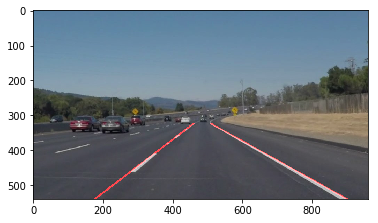

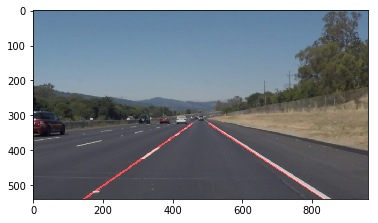

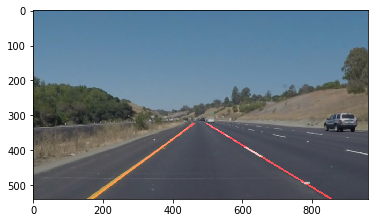

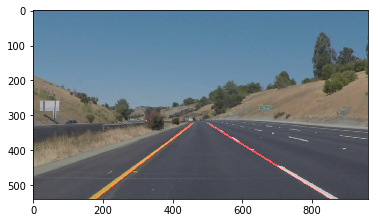

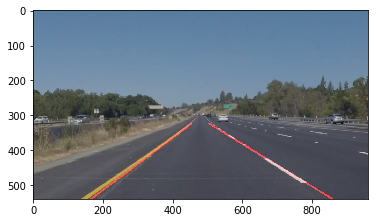

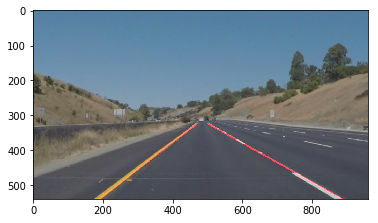

In [7]:
for filename in filenames:
    image = mpimg.imread('test_images/%s' % filename)
    result_image = image_with_full_lines(image)
    plt.figure()
    plt.imshow(result_image)

## Test on Videos

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = image_with_full_lines(image)
    return result

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:08<00:00, 26.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.34 s, sys: 1.33 s, total: 5.67 s
Wall time: 9.87 s


In [314]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Test on a video with a yellow line.

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:27<00:00, 24.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 14.1 s, sys: 4.06 s, total: 18.2 s
Wall time: 28.9 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

In [20]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:21<00:00,  8.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 11.2 s, sys: 2.81 s, total: 14 s
Wall time: 25 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))